<a href="https://colab.research.google.com/github/likoscp/face_detection/blob/main/Face_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Разархивация

In [55]:
# faces_zip = "/content/drive/MyDrive/face.zip"
# robots_zip = "/content/drive/MyDrive/robots.zip"
# animal_zip = "/content/drive/MyDrive/animal.zip"
# items_zip = "/content/drive/MyDrive/items.zip"
# fake_faces_zip = "/content/drive/MyDrive/fake_faces.zip"
# anime_faces_zip = "/content/drive/MyDrive/anime_faces.zip"

# !mkdir -p /content/dataset/face
# !mkdir -p /content/dataset/robots
# !mkdir -p /content/dataset/animal
# !mkdir -p /content/dataset/items
# !mkdir -p /content/dataset/fake_faces
# !mkdir -p /content/dataset/anime_faces

# !unzip -qo $faces_zip -d /content/dataset/face
# !unzip -qo $robots_zip -d /content/dataset/robots
# !unzip -qo $animal_zip -d /content/dataset/animal
# !unzip -qo $items_zip -d /content/dataset/items
# !unzip -qo $fake_faces_zip -d /content/dataset/fake_faces
# !unzip -qo $anime_faces_zip -d /content/dataset/anime_faces
dataset_dir = "/content/dataset"
dataset = "/content/drive/MyDrive/dataset.zip"
if not os.path.exists(dataset_dir):
    !mkdir -p /content/dataset
    !unzip -qo $dataset -d /content/dataset/
# !zip -r dataset.zip /content/dataset

импорт

In [56]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, datasets
import matplotlib.pyplot as plt
import os, shutil
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
import random
from PIL import Image
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize


Импорт кагл

сплит

In [57]:
def split_dataset(src_dir, dst_root, class_name, split=(0.7,0.2,0.1)):
    files = os.listdir(src_dir)
    np.random.shuffle(files)

    n_total = len(files)
    n_train = int(split[0] * n_total)
    n_val = int(split[1] * n_total)

    train_files = files[:n_train]
    val_files = files[n_train:n_train+n_val]
    test_files = files[n_train+n_val:]

    for subdir in ["train", "val", "test"]:
        os.makedirs(os.path.join(dst_root, subdir, class_name), exist_ok=True)

    for f in train_files:
        shutil.copy(os.path.join(src_dir, f), os.path.join(dst_root, "train", class_name, f))
    for f in val_files:
        shutil.copy(os.path.join(src_dir, f), os.path.join(dst_root, "val", class_name, f))
    for f in test_files:
        shutil.copy(os.path.join(src_dir, f), os.path.join(dst_root, "test", class_name, f))

In [58]:
split_dataset("/content/dataset/face", "/content/dataset_ready", "face")
split_dataset("/content/dataset/robots", "/content/dataset_ready", "robots")
split_dataset("/content/dataset/animal", "/content/dataset_ready", "animal")
split_dataset("/content/dataset/items", "/content/dataset_ready", "items")
split_dataset("/content/dataset/fake_faces", "/content/dataset_ready", "fake_faces")
split_dataset("/content/dataset/anime_faces", "/content/dataset_ready", "anime_faces")


Ресайз самых больших (код был использован до ресайз до 224Х224)

In [59]:
# from PIL import Image

# data_dir = "/content/dataset/face"
# max_size = (1280, 1280)

# def resize_big_images(data_dir, max_size=(1280,1280)):
#     for root, dirs, files in os.walk(data_dir):
#         for f in files:
#             path = os.path.join(root, f)
#             try:
#                 img = Image.open(path)
#                 if img.size[0] * img.size[1] > 894788:
#                     print(f"Resizing {path} from {img.size}...")
#                     img.thumbnail(max_size, Image.Resampling.LANCZOS)
#                     img.save(path)
#             except Exception as e:
#                 print(f"Error с {path}: {e}")

# resize_big_images(data_dir, max_size=(1280,1280))


Обучение простой цнн

In [60]:
from tensorflow.keras import layers, models
dataset_root = "/content/dataset_ready"
img_size = (128, 128)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = train_datagen.flow_from_directory(
    dataset_root + "/train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

val_datagen = ImageDataGenerator(rescale=1./255)

val_gen = val_datagen.flow_from_directory(
    dataset_root + "/val",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    dataset_root + "/test",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

model_cnn = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(train_gen.num_classes, activation="softmax")
])

model_cnn.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

history = model_cnn.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[early_stop]
)

test_loss, test_acc = model_cnn.evaluate(test_gen)
print(f"Test accuracy: {test_acc:.4f}")

model_cnn.save("/content/simple_cnn.h5")


Found 1072 images belonging to 6 classes.
Found 306 images belonging to 6 classes.
Found 158 images belonging to 6 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 218ms/step - accuracy: 0.1914 - loss: 1.7605 - val_accuracy: 0.4248 - val_loss: 1.3917
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - accuracy: 0.4356 - loss: 1.3905 - val_accuracy: 0.4608 - val_loss: 1.2252
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.4943 - loss: 1.2716 - val_accuracy: 0.5556 - val_loss: 1.1484
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - accuracy: 0.4887 - loss: 1.2103 - val_accuracy: 0.5392 - val_loss: 1.1573
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.5561 - loss: 1.1451 - val_accuracy: 0.5784 - val_loss: 1.0684
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.5569 - loss: 1.0715 - val_accuracy: 0.5915 - val_loss: 1.0513
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - accuracy: 0.5910 - loss: 1.0567 - val_accuracy: 0.6111 - val_loss: 1.0064
Epoch 8/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.5906 - loss: 1.0096 - val_accuracy: 0

Test accuracy: 0.6203


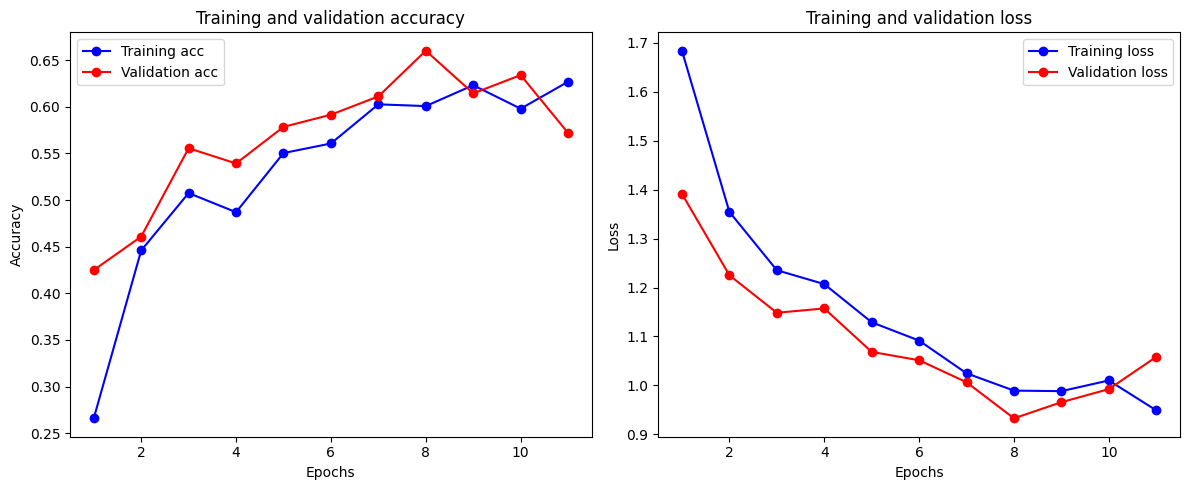

In [61]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc, "bo-", label="Training acc")
plt.plot(epochs, val_acc, "ro-", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, "bo-", label="Training loss")
plt.plot(epochs, val_loss, "ro-", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step


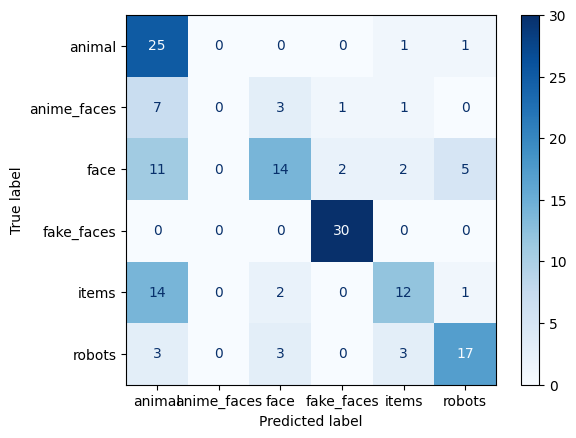

In [62]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_test = np.argmax(model_cnn.predict(test_gen, verbose=1), axis=1)
y_test = test_gen.labels

cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_gen.class_indices.keys()))
disp.plot(cmap='Blues')


In [63]:
# !rm -rf /content/dataset_ready
# !rm -rf /content/dataset

Уже готовая моделька K_mean

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Found 158 images


100%|██████████| 158/158 [00:00<00:00, 210.05it/s]


KMeans clustering accuracy: 0.1519


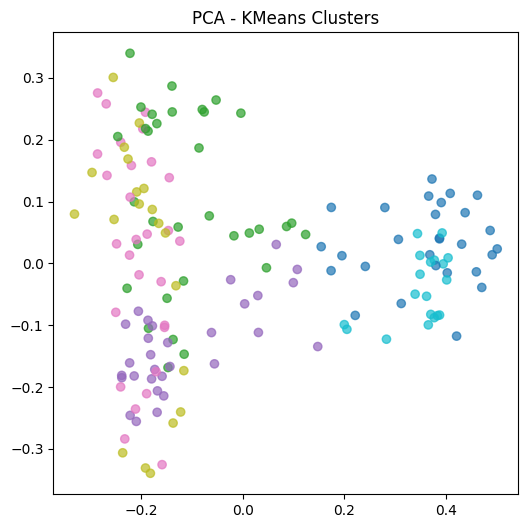

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


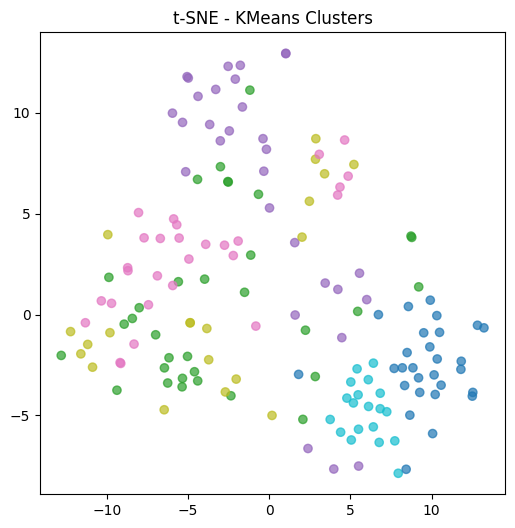

In [64]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
dirs = {
    "face": "/content/dataset_ready/test/face",
    "fake_faces": "/content/dataset_ready/test/fake_faces",
    "robots": "/content/dataset_ready/test/robots",
    "animal": "/content/dataset_ready/test/animal",
    "items": "/content/dataset_ready/test/items",
    "anime_faces": "/content/dataset_ready/test/anime_faces"
}
# dirs = {
#     "face": "dataset_ready/train/face",
#     "fake_faces": "dataset_ready/train/fake_faces",
#     "robots": "dataset_ready/train/robots",
#     "animal": "dataset_ready/train/animal",
#     "items": "dataset_ready/train/items",
#     "anime_faces": "dataset_ready/train/anime_faces"
# }

image_paths, true_labels = [], []
for label_idx, (label_name, d) in enumerate(dirs.items()):
    for f in os.listdir(d):
        if f.lower().endswith((".jpg", ".jpeg", ".png")):
            image_paths.append(os.path.join(d, f))
            true_labels.append(label_idx)


print(f"Found {len(image_paths)} images")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

device = "cuda" if torch.cuda.is_available() else "cpu"
model = models.resnet18(pretrained=True)
model.fc = nn.Identity()
model = model.to(device).eval()

embeddings = []
for path in tqdm(image_paths):
    img = Image.open(path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        feat = model(x).cpu().numpy().flatten()
    embeddings.append(feat)

embeddings = np.vstack(embeddings)

embeddings_norm = normalize(embeddings)

kmeans = KMeans(n_clusters=len(dirs), random_state=42)
labels_kmeans = kmeans.fit_predict(embeddings_norm)

acc1 = accuracy_score(true_labels, labels_kmeans)
acc2 = accuracy_score(true_labels, 1 - labels_kmeans)
acc = max(acc1, acc2)
print(f"KMeans clustering accuracy: {acc:.4f}")

pca = PCA(n_components=2)
X_pca = pca.fit_transform(embeddings_norm)

plt.figure(figsize=(6,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_kmeans, cmap="tab10", alpha=0.7)
plt.title("PCA - KMeans Clusters")
plt.show()

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(embeddings_norm)

plt.figure(figsize=(6,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=labels_kmeans, cmap="tab10", alpha=0.7)
plt.title("t-SNE - KMeans Clusters")
plt.show()


Старый код ФРЦНН

In [65]:
import torch
import torchvision
import torchvision.transforms as T
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

COCO_PERSON_LABEL = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()
model.to(device)

def predict_image(model, device, image, thr=0.5):

    if isinstance(image, np.ndarray):
        image = Image.fromarray((image * 255).astype(np.uint8))

    transform = T.Compose([T.ToTensor()])
    tensor = transform(image).to(device)

    with torch.no_grad():
        outputs = model([tensor])

    outputs = outputs[0]
    boxes = outputs['boxes'].cpu()
    labels = outputs['labels'].cpu()
    scores = outputs['scores'].cpu()

    person_indices = [i for i, lbl in enumerate(labels)
                      if lbl.item() == COCO_PERSON_LABEL and scores[i].item() >= thr]

    persons = [{'box': boxes[i].tolist(), 'score': float(scores[i].item())} for i in person_indices]
    return image, persons

def draw_boxes(image, persons):
    draw = ImageDraw.Draw(image)
    try:
        font = ImageFont.load_default()
    except Exception:
        font = None

    for p in persons:
        x1, y1, x2, y2 = p['box']
        draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
        label = f"person: {p['score']:.2f}"

        if font:
            bbox = draw.textbbox((x1, y1), label, font=font)
            text_w, text_h = bbox[2] - bbox[0], bbox[3] - bbox[1]
        else:
            text_w, text_h = 50, 10

        draw.rectangle([x1, y1 - text_h, x1 + text_w, y1], fill="red")
        draw.text((x1, y1 - text_h), label, fill="white", font=font)
    return image


def process_image(image_path, thr=0.5):
    img, persons = predict_image(model, device, image_path, thr)
    if persons:
        print(f"Person detected: {len(persons)} (threshold={thr})")
    else:
        print(f"No person detected (threshold={thr})")

    annotated = draw_boxes(img.copy(), persons)
    plt.figure(figsize=(8, 8))
    plt.imshow(annotated)
    plt.axis("off")
    plt.show()


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [66]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, models, optimizers
model_deep_cnn = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3,3), activation="relu", padding="same", input_shape=(img_size[0], img_size[1], 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3,3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3,3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),

    layers.Conv2D(256, (3,3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3,3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dense(512, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(train_gen.num_classes, activation="softmax")
])

model_deep_cnn.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

history_deep = model_deep_cnn.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[early_stop, reduce_lr]
)

test_loss, test_acc = model_deep_cnn.evaluate(test_gen)
print(f"Deep CNN Test Accuracy: {test_acc:.4f}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 31s 493ms/step - accuracy: 0.2776 - loss: 2.5689 - val_accuracy: 0.1895 - val_loss: 1.8485 - learning_rate: 1.0000e-04
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - accuracy: 0.4508 - loss: 1.8638 - val_accuracy: 0.2157 - val_loss: 1.9218 - learning_rate: 1.0000e-04
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - accuracy: 0.4778 - loss: 1.7569 - val_accuracy: 0.1895 - val_loss: 2.0183 - learning_rate: 1.0000e-04
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.4914 - loss: 1.6006
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 188ms/step - accuracy: 0.4917 - loss: 1.6001 - val_accuracy: 0.2745 - val_loss: 2.0964 - learning_rate: 1.0000e-04
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 164ms/step - accuracy: 0.5478 - loss: 1.4420 - val_accuracy: 0.1863 - val_loss: 2.5055 - learning_rate: 5.0000e-05
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.52

In [67]:
from tensorflow.keras.applications import MobileNetV2
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(img_size[0], img_size[1], 3))
base_model.trainable = False

model_mobilenet = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dense(train_gen.num_classes, activation="softmax")
])

model_mobilenet.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

history_mobilenet = model_mobilenet.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[early_stop]
)

test_loss_m, test_acc_m = model_mobilenet.evaluate(test_gen)
print(f"MobileNetV2 Test Accuracy: {test_acc_m:.4f}")

Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 490ms/step - accuracy: 0.5573 - loss: 1.1111 - val_accuracy: 0.8856 - val_loss: 0.3033
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.9400 - loss: 0.1846 - val_accuracy: 0.8922 - val_loss: 0.2939
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - accuracy: 0.9728 - loss: 0.1093 - val_accuracy: 0.9085 - val_loss: 0.2477
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.9673 - loss: 0.1109 - val_accuracy: 0.9052 - val_loss: 0.2636
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - accuracy: 0.9852 - loss: 0.0649 - val_accuracy: 0.9183 - val_loss: 0.2456
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 0.9703 - loss: 0.0833 - val_accuracy: 0.9052 - val_loss: 0.3085
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9837 - loss: 0.0674 - val_accuracy: 0.9248 - val_loss: 0.2183
Epoch 8/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - accuracy: 0.9677 - loss: 0.0780 - val_accuracy: 0

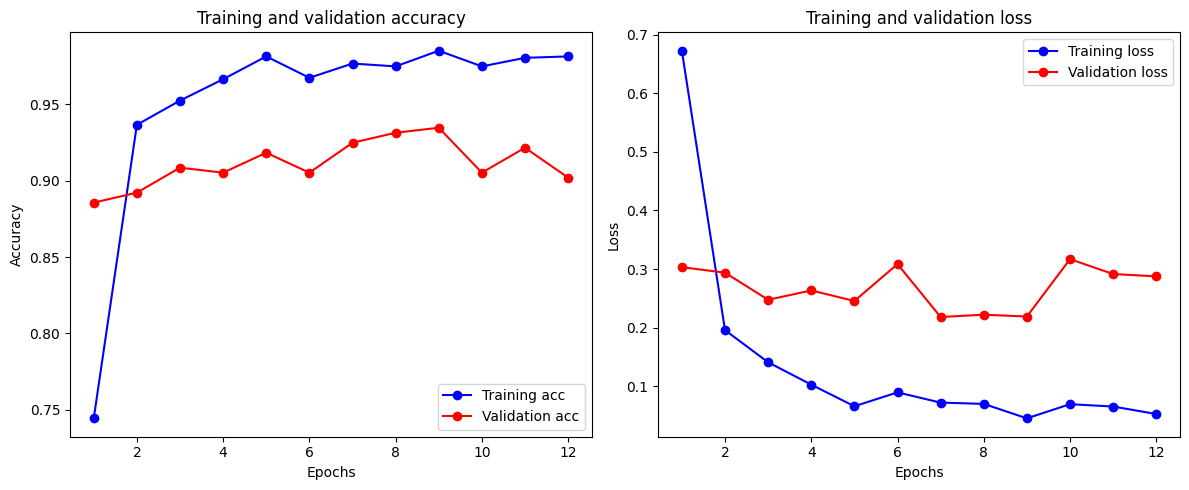

In [68]:
acc = history_mobilenet.history['accuracy']
val_acc = history_mobilenet.history['val_accuracy']
loss = history_mobilenet.history['loss']
val_loss = history_mobilenet.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc, "bo-", label="Training acc")
plt.plot(epochs, val_acc, "ro-", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, "bo-", label="Training loss")
plt.plot(epochs, val_loss, "ro-", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step


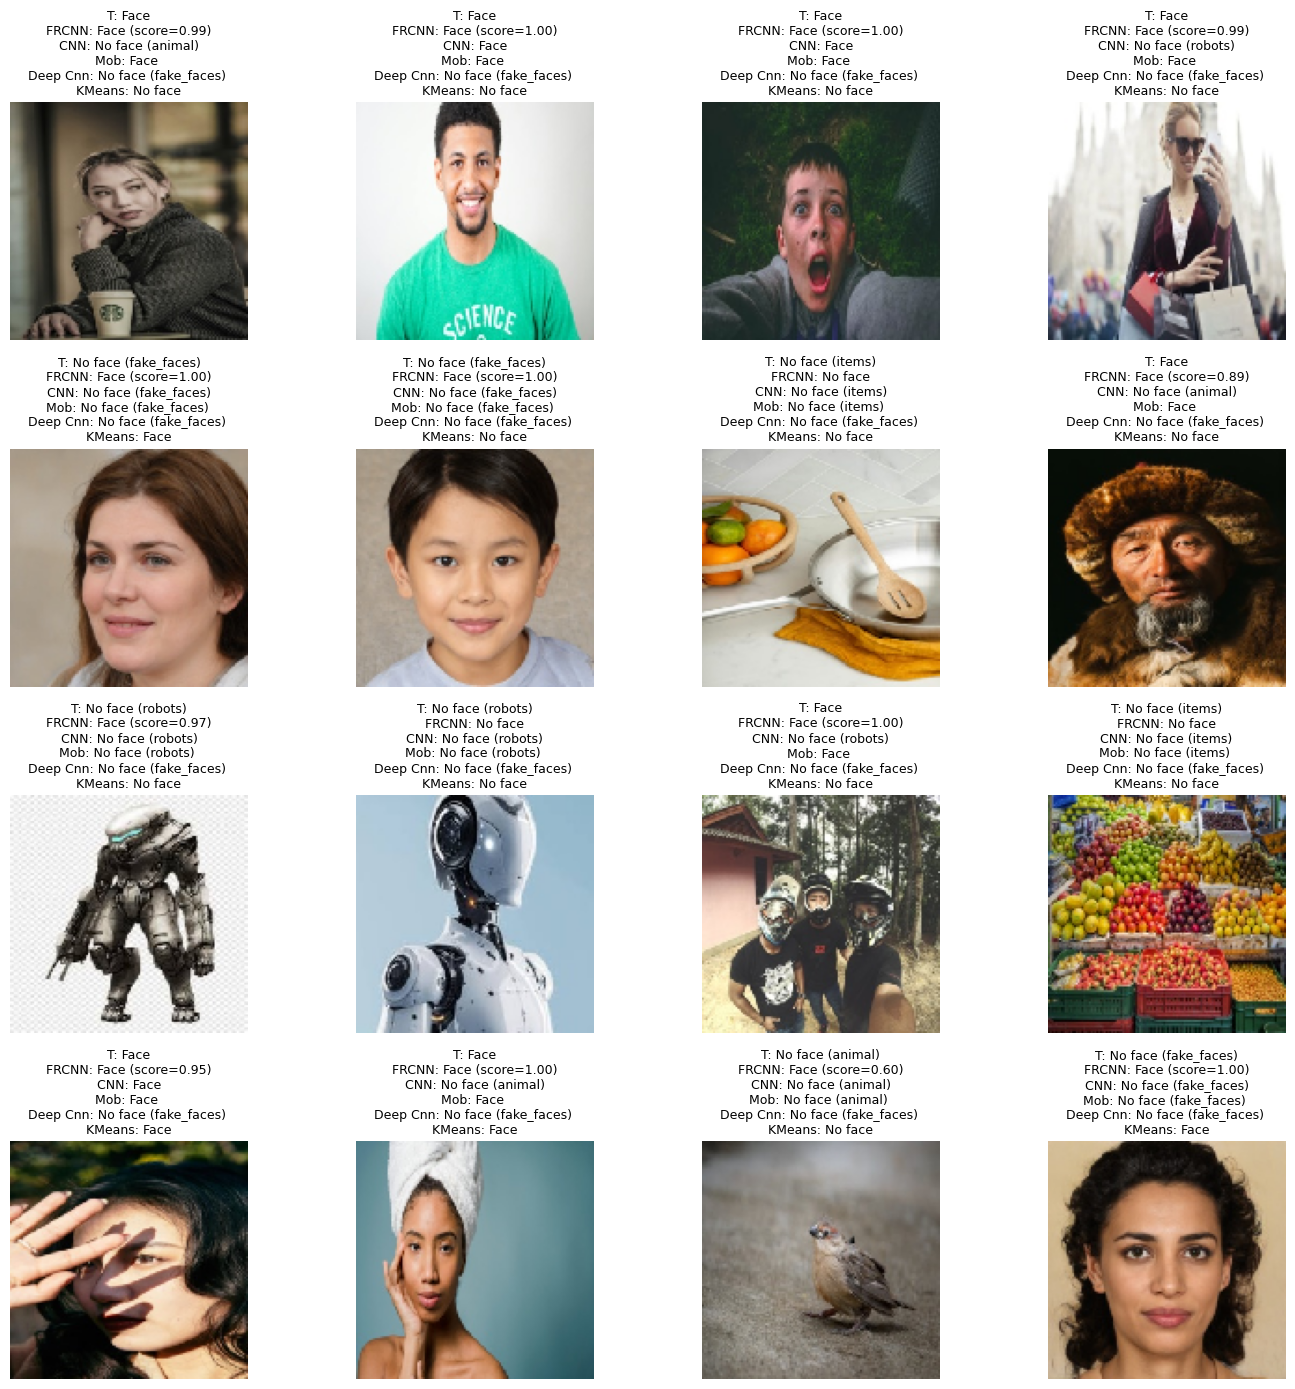

In [69]:
class_names = list(train_gen.class_indices.keys())
face_index = class_names.index("face")

all_x, all_y = [], []

for i in range(len(test_gen)):
    x_batch_gen, y_batch_gen = test_gen[i]
    all_x.append(x_batch_gen)
    all_y.append(np.argmax(y_batch_gen, axis=1))

all_x = np.vstack(all_x)
all_y = np.hstack(all_y)
all_paths = test_gen.filepaths

face_indices = [i for i, y in enumerate(all_y) if y == face_index]
other_indices = [i for i, y in enumerate(all_y) if y != face_index]

selected_face_idx = random.sample(face_indices, 8)
selected_other_idx = random.sample(other_indices, 8)
selected_indices = selected_face_idx + selected_other_idx
random.shuffle(selected_indices)

x_batch = all_x[selected_indices]
y_batch = all_y[selected_indices]
selected_paths = [all_paths[i] for i in selected_indices]

y_true = y_batch
y_pred = np.argmax(model_cnn.predict(x_batch), axis=1)
y_mob = np.argmax(model_mobilenet.predict(x_batch), axis=1)
y_deep = np.argmax(model_deep_cnn.predict(x_batch), axis=1)

path_to_index = {p: i for i, p in enumerate(image_paths)}
kmeans_labels_dict = {}
for p in selected_paths:
    if p in path_to_index:
        kmeans_labels_dict[p] = labels_kmeans[path_to_index[p]]
    else:
        kmeans_labels_dict[p] = 0

plt.figure(figsize=(14, 14))
for i in range(16):
    plt.subplot(4, 4, i+1)

    img_array = (x_batch[i] * 255).astype("uint8")
    plt.imshow(img_array)
    plt.axis("off")

    true_label = "Face" if y_true[i] == face_index else f"No face ({class_names[y_true[i]]})"
    pred_label = "Face" if y_pred[i] == face_index else f"No face ({class_names[y_pred[i]]})"
    mob_label = "Face" if y_mob[i] == face_index else f"No face ({class_names[y_mob[i]]})"
    deep_label = "Face" if y_deep[i] == face_index else f"No face ({class_names[y_deep[i]]})"
    kmeans_pred = "Face" if kmeans_labels_dict[selected_paths[i]] == 0 else "No face"
    img_pil = Image.fromarray(img_array)
    _, persons = predict_image(model, device, img_pil, thr=0.5)

    if persons:
        max_score = max(p['score'] for p in persons)
        frcnn_label = f"Face (score={max_score:.2f})"
    else:
        frcnn_label = "No face"

    plt.title(f"T: {true_label}\nFRCNN: {frcnn_label}\nCNN: {pred_label}\nMob: {mob_label} \nDeep Cnn: {deep_label} \nKMeans: {kmeans_pred}", fontsize=9)


plt.tight_layout()
plt.show()


